# ECE 105 Homework 2

**Please turn in a PDF with all your outputs along with your jupyter notebook when you upload your assignment on BBLearn. You can find the details to convert a notebook into a PDF at the bottom of this notebook.**

**This code will take time to run so please understand that it is not possible for the TA's to run all your notebooks. If you face issues converting your notebook, then upload your plot as an image or PDF along with your analysis of the plot in the comment section in BBLearn portal. If you face errors in doing either then make sure to write that in the comment section too so that we know what went wrong. Again, do not turn in your notebook without any description.**

## Multi Armed Bandit (MAB) problem

The second homework assignment for this week is to write code that simulates playing the multi-armed bandit (MAB), in which one can set a bet amount each play.  As one of the arms will be superfair (although we don't know which one, a priori), we will use the Kelly criterion to establish the bet size, once we believe we've identified the best arm to pull.  You will be given starter code which you will be asked to complete.

The strategy is a natural combination of the concepts covered in the MAB laboratory (Lab 2) and the Kelly betting strategy covered in lecture (Lecture 2).  Given an MAB with $m$ arms for which we have are allowed $n$ pulls, we will divide between an explore phase and an exploit phase.  The parameter $k$ will be the number of pulls of each arm that is made in the explore phase.  On the basis of the outcomes of those pulls, we estimate which arm is the best.  

In the subsequent exploit phase, we repeatedly pull the arm identified in the explore phase, but now begin to place bets.  As the win probability is unknown, we maintain a running estimate of the win probability on the chosen arm, $p_{\rm est}$, and choose the bet size using the Kelly criterion with that estimate: 
\begin{equation*}
f_{\rm est} = 2 * p_{\rm est} - 1.
\end{equation*}

We will also use minimum and maximum fractions for betting, $f_{\rm min}, f_{\rm max}$, to avoid boundary problems:
\begin{equation*}
f_{\rm est} = \min(\max(2 * p_{\rm est} - 1, f_{\rm min}), f_{\rm max}).
\end{equation*}
Note that $f_{\rm min} \leq f_{\rm est} \leq f_{\rm max}$.  The reason for the boundaries is to keep the betting fraction from the extremes of $0$ and $1$.  First, if we estimate that $p < 1/2$ then the Kelly criterion says to not bet (as the growth rate for any subfair game is negative); using $f_{\rm min}$ ensures we always bet something.  Second, if we estimate that $p = 1$ (as will be the case when all plays result in 'w'), then the Kelly criterion says to bet everything. 

The tension between explore and exploit is captured by $k$.  If $k$ is too small, then it is possible that the gambler will settle on the incorrect arm, in which case the subsequent wealth growth rate will be suboptimal.  If $k$ is too large, then the gambler will almost certainly find the right arm, but will have wasted valuable time in discovering it, and will not have enough pulls in the exploit phase to reach the optimal growth rate.

## Starter code for MAB

Please read and understand the the function blocks that are provided below before you start working on the assignment.

In [46]:
"""
Multi-armed bandit (MAB)
"""
import numpy as np
import matplotlib.pyplot as plt

### r_inf(f, p): expected rate of wealth growth under Kelly betting

This function block returns the expected rate of wealth growth under Kelly betting. It takes in the fraction of wealth to bet $f$ and the probability of winning on a machine $p$ and returns the following 

$$r_{inf} = p\log_2(1+f)+(1-p)\log_2(1-f)$$

In [47]:
"""
def r_inf(f,p)
input f: fraction of wealth to bet
input p: probability of winning
return: expected rate of wealth growth under Kelly betting
"""
def r_inf(f, p):
    return p * np.log2(1+f) + (1-p) * np.log2(1-f)


### pull_arm(p,n): list of n random arm pull outcomes for win prob. p

This function block returns an array of size $n$ where the elements are 1 or 0 where 1 represents a win and 0 a loss. It takes in the probability of winning $p$ on a machine and the size $n$ which is the number of pulls you want and returns the array which the holds the number of wins and losses over the $n$ pulls

In [48]:
"""
def pull_arm(p, n)
input p: probability of winning
input n: number of pulls
return: list of n random arm pull outcomes for win prob. p
"""
def pull_arm(p, n):
    return np.random.choice(['w','l'], p=[p, 1-p], size=n)

### create\_MAB(m,n): array of n random arm pull outcomes for each win prob. pe in p

This function block returns a matrix where each row of the matrix is an array of size $n$ holding the wins and losses for each machine $i \in {1,..,m}$. Precisely, it return a $m x n$ matrix

In [49]:
"""
def create_MAB(p, n)
input p: probability of winning
input n: number of pulls
return: array of n random arm pull outcomes for each win prob. pe in p
"""
def create_MAB(p, n):
    return np.array([pull_arm(pe, n) for pe in p])

### w_to_r(w): convert wealth sequence to a wealth growth rate sequence

This function block converts a wealth sequence to it's equivalent growth rate i.e. it takes in wealth sequence $w$ as input and returns the following 

$$w\_to\_r = \frac{\log_2(\frac{w_i}{w_0})}{i} \quad \forall i \in w$$

In [50]:
"""
def w_to_r(w)
input w: a wealth sequence
return: a wealth growth rate sequence
"""
def w_to_r(w): # convert a wealth sequence into growth rate
    return [np.log2(w[t]/w[0])/t for t in range(1,len(w))]


### play_OAB(m, w0, f_min, f_max): play a one-armed bandit (OAB) with pull outcomes $m$, initial wealth $w_0$, and betting fraction limits $f_{\rm min},f_{\rm max}$

play an instance of the one-armed bandit problem

In [51]:
"""
def play_OAB(m, w0, f_min, f_max)
input m: arm pull outcomes, each a 'w' or 'l'
input w0: initial wealth of the gambler
input f_min: minimum fraction of wealth to bet
input f_max: maximum fraction of wealth to bet
"""
def play_OAB(m, w0, f_min, f_max):
    """
    initialize variables:
    c: number (count) of wins so far
    f_est: Kelly bet using estimated prob. of winning
    w: wealth sequence, initialized with initial wealth
    """
    c, f_est, w = 0, f_min, [w0]
    """
    pull the arm len(m) times, and for each pull i:
    compute the bet b as the fraction f_est of wealth w[-1]
    update wealth sequence by adding or subtracting bet b
    update count c of number of wins
    update estimate p_est of the probability of winning
    update bet fraction f_est using Kelly criterion and min/max
    """
    for i in range(len(m)):
        b = f_est * w[-1]
        w.append(w[-1] + b if m[i] == 'w' else w[-1] - b)
        if m[i] == 'w': c = c + 1
        p_est = c/(i + 1)
        f_est = min(max(2 * p_est - 1, f_min), f_max)
    """
    compute the wealth sequence w to a rate sequence r
    and return it and the count of wins
    """
    return w_to_r(w), c

### plot\_MAB(n, p, R, f\_min, f\_max): plot the growth rate sequences $R$ against the number of pulls $n$, when arms have success probabilities $p$ and the gambler used betting fraction limits $f_{\rm min},f_{\rm max}$.  

The array $R$ is $m+1 \times n$ and holds $m+1$ growth rate sequences.  The first $m$ elements of $R$ are the growth rate sequences when the gambler picks each of the $m$ arms and only pulls it for all $m$ trials, making Kelly-sized bets at each play.  The last element in $R$ is the growth rate sequence when the gambler first explores each arm using $k$ pulls each, not gambling during the explore phase, then gambling using Kelly-sized bets on the remaining $n - m k$ pulls of the selected arm.

In [52]:
"""
def plot_MAB(n, p, R, f_min, f_max)
input n: number of pulls
input p: probability of winning
input R: wealth growth rate sequences for each arm and for MAB
input f_min: minimum fraction of wealth to bet
input f_max: maximum fraction of wealth to bet
"""
def plot_MAB(n, p, R, f_min, f_max):
    plt.figure()
    [plt.plot(range(n), r, label='p={}'.format(pe)) for r, pe in zip(R, p)]
    plt.xlabel('number of pulls (n)')
    plt.ylabel('wealth growth rate')
    plt.title('MAB performance')
    """
    add horizontal gridlines at the growth rates for each arm (pe in p)
    using optimal Kelly betting, noting each fe = 2*p-1 is limited to
    lie between f_min and f_max
    """
    f = [min(max(2*pe-1,f_min),f_max) for pe in p]
    [plt.axhline(y=r_inf(fe,pe), color='black', linewidth=1) for fe, pe in zip(f,p)]
    plt.legend()
    plt.ylim(-0.05,+0.05)
    plt.savefig("HW2Solution-v1-Output.pdf")
    plt.show()

# Implement the following for HW

**For the homework you have to implement the est_MAB function, run the main script and generate a plot for specific game instance.**

### est\_MAB(M, k): use $k$ pulls on each arm of the MAB, using the appropriate outcomes from array $M$, and return the arm index estimated to have the highest win probability

In [53]:
"""
def est_MAB(M, k)
input M: an array of outcomes for each of the arms
input k: number of "explore" pulls on each arm


iterate over the arms, indexed by a, and for each arm:
    extract the outcomes for those pulls, M[a, a*k : (a+1)*k]
    call play_OAB using those outcomes
    do not bet: set min and max bet fraction to 0: f_min = f_max = 0
    retain only the count c of wins returned by play_OAB
    """
def est_MAB(M,K):
    c=[]
    for a in range(len(M)):
        m=M[a,a*k:(a+1)*k]
        c.append(play_OAB(m,1,0,0)[1])
    a=max(c)
    D=c.index(a)
    return D
    


### Main script: define the appropriate constants, and use the above functions to simulate the experiment and plot the results.

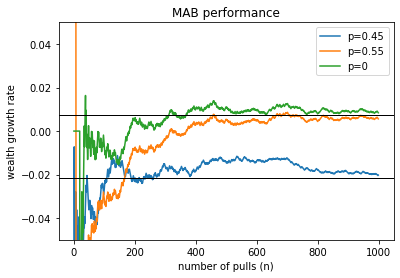

In [54]:
"""
main script
parameters:
m: number of arms on the MAB
p: a list of length m holding the win probabilities for each arm
n: number of trials (arm pulls) allowed
w0: initial wealth of the gambler
f_min: minimum fraction of wealth to bet
f_max: maximum fraction of wealth to bet
k: number of trial pulls, without betting, for each arm, to estimate p
"""
m, p, n, w0, f_min, f_max, k = 2, [0.45, 0.55], 1000, 1, 1/10, 9/10, 10
# create the MAB, return the m * n array of pull outcomes ('w', 'l') as M
M = create_MAB(p, n)
# compute wealth growth rate playing each arm for all trials
# only keep argument 0, the growth rate sequence
R = [play_OAB(Me, w0, f_min, f_max)[0] for Me in M]
# estimate the best arm using k draws on each arm
a_est = est_MAB(M, k)
# m_est holds the outcomes for the remaining pulls on the chosen arm
m_est = M[a_est, m*k : ]
# r_MAB is wealth growth rate using chosen arm
# only keep argument 0, the growth rate sequence
r_MAB = play_OAB(m_est, w0, f_min, f_max)[0]
# prepend r_MAB wealth growth rate sequence with m*k zeros from explore phase
r_MAB = [0]*(m*k) + r_MAB
# add r_MAB to list of results to be plotted
R.append(r_MAB)
"""
plot the results
p.append(0) means append a 0 to the list of win probabilities
this 0 is used as a label in the plot, and identifies the MAB
explore/exploit strategy's growth rate curve
"""
p.append(0)
plot_MAB(n, p, R, f_min, f_max)

### Analyze and comment below on the plot that you got  

You don't have to be too descriptive about the analysis. A simple intutive explanation would also work as long it is clear to us that you understood what you were doing

In this graph, we are pulling 1000 times. In order to maximize the rate of wealth growth we need to analyze the arm which has the highest probability of winning. As we can see that in this graph the p=0.55 is the most wanted in order to maximize the chances of incrasing the wealth growth rate.

### How to save a .ipynb file as a pdf 

Please note that you might face issues if you directly try to convert this notebook to pdf by using the "download as" option from the dropdown menu under File above. You may skip the steps below if you already know how to convert it into pdf. If you don't then do the following:

1) run the command "conda install nbconvert" or "pip install nbconvert" from your terminal depending on whether you are using anaconda to run python or not. If you are using anaconda then run the former command otherwise latter.

2) Once you have succesfully installed the nbconvert module, go to the directory from your terminal where you notebook is saved and run the command "jupyter nbconvert name_of_your_notebook.ipynb --to pdf". This command will convert your .ipynb file to a pdf

Please reach out to us if you face any issues.